# This notebook introduces self-attention (scaled-dot product attention) mechanism and LLM architecture

In [1]:
import torch

from utils import display_matrix_dimension

# 1. Simple self-attention mechanism (w/o trainable weights)

<img src="./images/Attention_mechansim-Attentions_simplified.png" alt="" width="1100" height="200">

## 1.1. Creating dummy input embeddings.

<img src="./images/Attention_mechansim-input_embeddings.png" alt="" width="250" height="550">

#### First let's create a dummy input embedding with the shape of (6 x 3)

In [2]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

display_matrix_dimension(inputs, x_name="Input embedding vectors")


>>> Input embedding vectors dimensions: 6 rows, 3 columns


#

## 1.2. Attention scores

#### Now let's select a second row as a query and calculate its attention scores.

<img src="./images/Attention_mechansim-attention_score.png" alt="" width="800" height="450">

- Attention score is a dot-product between query and all input embedding vectors.
- A dot-product is the element-wise multiplication of two vectors and summing the products.

<img src="./images/Attention_mechansim-dot_product_attention_score.png" alt="" width="800" height="325">

The following cell of codes calculate the attention scores of second input embedding, $x^{(2)}$ which is selected as query.

In [3]:
query = inputs[1]  # 2nd input token (2nd row of inputs) is the query

attn_scores_2 = torch.empty(inputs.shape[0])  # 1 x 6 placeholder tensor
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(f"Attention scores of query: \n{attn_scores_2}")


Attention scores of query: 
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


## 1.3. Attention weights

#### Attention weights the normalized attention scores which sum up to 1.

<img src="./images/Attention_mechansim-attention_weights.png" alt="" width="800" height="500">

The code below shows the simple normalization of second input token attention scores.

In [4]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()  # 

print(f"Attention weights of query (second input embedding vector): \n{attn_weights_2_tmp}")
print("Sum of attention scores:", attn_weights_2_tmp.sum())


Attention weights of query (second input embedding vector): 
tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum of attention scores: tensor(1.0000)


#### In pratice, softmax function is commonly used to normalize the attention scores to get attention weights for better handling extreme values and gradient properties during training.

<img src="./images/Attention_mechansim-softmax.png" alt="" width="400" height="250">

- In the following code, we use PyTorch implementation of softmax function to calculate attention weights which is highly optimized.

In [5]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights of query:", attn_weights_2)
print("Sum:", attn_weights_2.sum())


Attention weights of query: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


## 1.4. Context vector

### 1.4.1. Context vector w.r.t second input embedding vector

<img src="./images/Attention_mechansim-Context_vector.png" alt="" width="800" height="500">

- We calculate the context vector, $z^{(2)}$ w.r.t second input embedding vector, $x^{(2)}$ by multiplying the embedding input tokens, $x^{(i)}$ with attention weights, $⍺_{(2i)}$ and summing the resulting vectors.

In [6]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)  # context vector has same dimension as query

# Multiply attention weights and input embedding vectors
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(f"Context vector w.r.t query: \n{context_vec_2}")


Context vector w.r.t query: 
tensor([0.4419, 0.6515, 0.5683])


### 1.4.2. Context vectors for all input embeddings

#### First calculate attention scores for all input embeddings. 
<img src="./images/Attention_mechansim-All_attention_scores.png" alt="" width="1100" height="400">

- Dot-product between two input embeddings (6 x 3) would return a matrix of attention scores (6 x 6).

In [7]:
attn_scores = torch.empty(6, 6)

attn_scores = inputs @ inputs.T
print(f"Attention scores for all input embeddings: \n{attn_scores}\n")
display_matrix_dimension(attn_scores, x_name="Attention scores")


Attention scores for all input embeddings: 
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

>>> Attention scores dimensions: 6 rows, 6 columns


#### Next, normalize attention scores and calculate attention weights.
<img src="./images/Attention_mechansim-All_attention_weights.png" alt="" width="650" height="500">

- Utilize PyTorch softmax function for normalization.

In [8]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(f"Attention weights for all input embeddings: \n{attn_weights}\n")
display_matrix_dimension(attn_weights, x_name="Attention weights")


Attention weights for all input embeddings: 
tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

>>> Attention weights dimensions: 6 rows, 6 columns


#### Verify if adding attention weights along column axis results 1.

In [9]:
row_2_sum = sum(attn_weights[1])  # adding row 2 attention weights along column axis
print("Row 2 sum:", row_2_sum)

print("All row sums:", attn_weights.sum(dim=-1))  # adding all rows along column axis


Row 2 sum: tensor(1.)
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


#### Finally, calculate context vectors.

<img src="./images/Attention_mechansim-All_context_vectors.png" alt="" width="800" height="400">

- Context vectors are calculated by multiplying attention weights and input embeddings.

In [10]:
all_context_vecs = attn_weights @ inputs
print(f"Context vectors for all input embeddings: \n{all_context_vecs}")
display_matrix_dimension(all_context_vecs, x_name="Context vectors")


Context vectors for all input embeddings: 
tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])
>>> Context vectors dimensions: 6 rows, 3 columns


#### Notice the dimensions of context vectors and input embedding vectors dimensions are the same?

# 2. Self-attention mechanism w/ trainable weights (Scaled dot-product attention)

<img src="./images/Attention_mechansim-Attentions.png" alt="" width="1100" height="250">

## 2.1. Introducing self-attention mechanism utilized in original transformer, GPT and other popular LLMs.

<img src="./images/Attention_mechansim-Single-head_attention.png" alt="" width="800" height="800">

- We introduce three trainable weight matrices: $W_q$, $W_k$, and $W_v$.
  
- These three matrices are used to project the embedded input tokens, $x^{(i)}$, into query, key, and value vectors via matrix multiplication:

  - Query vector: $q^{(i)} = W_q \,x^{(i)}$
  - Key vector: $k^{(i)} = W_k \,x^{(i)}$
  - Value vector: $v^{(i)} = W_v \,x^{(i)}$

- Embedding dimensions of the input $x$ and the query vector $q$ can be the same or different, depending on the model's design and specific implementation.
- In GPT models, the input $x$ and the query vector $q$ embedding dimensions are usually the same.

In [11]:
x_2 = inputs[1]  # second input element
d_in = inputs.shape[1]  # the input embedding size, d=3
d_out = 2  # the output embedding size, d=2


- In the following code, we initialize the three weight matrices $W_q$, $W_k$, and $W_v$.
- Note that we are setting `requires_grad=False` to reduce clutter in the outputs for illustration purposes, but if we were to use the weight matrices for model training, we would set `requires_grad=True` to update these matrices during model training.

In [12]:
torch.manual_seed(123)

# Initialize three weight matrices
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)  # dimension: 3 x 2
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)  # dimension: 3 x 2
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)  # dimension: 3 x 2

display_matrix_dimension(W_query, x_name="Query Weight matrix")
display_matrix_dimension(W_key, x_name="Key Weight matrix")
display_matrix_dimension(W_value, x_name="Value Weight matrix")


>>> Query Weight matrix dimensions: 3 rows, 2 columns
>>> Key Weight matrix dimensions: 3 rows, 2 columns
>>> Value Weight matrix dimensions: 3 rows, 2 columns


#### For simplicity, we calculate query, key and value vectors w.r.t to second input embedding vector before we do that for all input embedding vectors.

<img src="./images/Attention_mechansim-q_k_v.png" alt="" width="1100" height="550">

In [13]:
query_2 = x_2 @ W_query  # _2 because it's w.r.t the 2nd input embedding vector
key_2 = x_2 @ W_key 
value_2 = x_2 @ W_value

print(f"Query vector for second input embedding: \n{query_2}\n") 
print(f"Key vector for second input embedding: \n{key_2}\n")
print(f"Value vector for second input embedding: \n{value_2}")


Query vector for second input embedding: 
tensor([0.4306, 1.4551])

Key vector for second input embedding: 
tensor([0.4433, 1.1419])

Value vector for second input embedding: 
tensor([0.3951, 1.0037])


### 2.1.1. First, compute keys and values vectors for all input embeddings

- Let's project 6 input tokens of from a 3D to 2D embedding space.

In [14]:
keys = inputs @ W_key 
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)


keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


### 2.1.2. Next, we compute attention score of second input embedding vector w.r.t second input embedding vector

<img src="./images/Attention_mechansim-trainable_attention_score.png" alt="" width="800" height="550">

In [15]:
keys_2 = keys[1]  # key vector for second input embedding
attn_score_22 = query_2.dot(keys_2)
print("Attention score of second embedding vector:\n", attn_score_22)


Attention score of second embedding vector:
 tensor(1.8524)


### 2.1.3. Next, we compute attention scores of all input embeddings w.r.t second input embedding.

In [16]:
attn_scores_2 = query_2 @ keys.T  # All attention scores for given query
print(attn_scores_2)


tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


### 2.1.4. We then calculate attention weights w.r.t second input embedding vector.

- We now scale the attention scores by dividing them by the square root of the embedding dimension, $\sqrt{d_k}$ (i.e., `d_k**0.5`) and normalize using softmax function to compute attention weights of all input embeddings w.r.t. second input embedding:

<img src="./images/Attention_mechansim-trainable_attention_weights.png" alt="" width="800" height="550">

- We normalize the attention scores by embedding dimension size is to improve training performance by avoid small gradients.
- Scaling by the square root of the embedding dimension is the reason why this is self-attention mechanism is called scaled-dot product attention.

In [17]:
d_k = keys.shape[1]  # w.r.t second input embedding
scaled_atten_scores = attn_scores_2 / d_k**0.5  # scaling by square root of embedding dimension
attn_weights_2 = torch.softmax(scaled_atten_scores, dim=-1)  # scaled attention weights w.r.t x_2
print(attn_weights_2)


tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


### 2.1.5 Finally, we calculate context vector of all input embeddings w.r.t second input dimension.

<img src="./images/Attention_mechansim-trainable_attention_context_vector.png" alt="" width="800" height="600">

In [18]:
context_vec_2 = attn_weights_2 @ values
print("Context vector w.r.t second input dimension: \n", context_vec_2)


Context vector w.r.t second input dimension: 
 tensor([0.3061, 0.8210])


## 2.2. A compact self-attention class

<img src="./images/Attention_mechansim-Single-head_attention.png" alt="" width="800" height="800">

- We can implement a compact self-attention mechanism w/ trainable weights as follows:

In [19]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):
    """Compact representation of scaled-dot product attention."""
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))


tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


- We can utilize the previous implementation using PyTorch's Linear layers, which are equivalent to a matrix multiplication if we disable the bias units
- Another big advantage of using `nn.Linear` over our manual `nn.Parameter(torch.rand(...)` approach is that `nn.Linear` has a preferred weight initialization scheme, which leads to more stable model training

In [20]:
class SelfAttention_v2(nn.Module):
    """A more optimized self-attention class"""
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))


tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


- Note that `SelfAttention_v1` and `SelfAttention_v2` give different outputs because they use different initial weights for the weight matrices

# 3. Causal attention

<img src="./images/Attention_mechansim-Causal_Attentions.png" alt="Context tokens" width="1100" height="250">

## 3.1. Masking future words with causal attention

### 3.1.1. Applying causal attention mask

- In causal attention, the attention weights above the diagonal are masked, ensuring that for any given input, the LLM is unable to utilize future tokens while calculating the context vectors with the attention weight

<img src="./images/Attention_mechansim-Masked_attention_weights.png" alt="Context tokens" width="1100" height="450">

- Causal self-attention ensures that the model's prediction for a certain position in a sequence is only dependent on the known outputs at previous positions, not on future positions
- In simpler words, this ensures that each next word prediction should only depend on the preceding words
- To achieve this, for each given token, we mask out the future tokens (the ones that come after the current token in the input text):

<img src="./images/Attention_mechansim-Modified_causal_attention.png" alt="Context tokens" width="450" height="500">

- The simplest way to mask out future attention weights is by creating a mask via PyTorch's tril function with elements below the main diagonal (including the diagonal itself) set to 1 and above the main diagonal set to 0:

## 3.2. Causal attention

<img src="./images/Attention_mechansim-Masked_single-head_attention.png" alt="Context tokens" width="550" height="500">

In [21]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)  # Dropout layer
        # Just to make sure tensors (buffers) are automatically moved to appropiate device (CPU or GPU) along with model
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2)  # Changed transpose
        # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # Mask attention scores
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)  # Dropout

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)


torch.Size([2, 6, 3])
tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


# 4. Multi-head attention

<img src="./images/Attention_mechansim-MHA_Attentions.png" alt="Context tokens" width="1100" height="250">

### Multi-head attention with stacked attention weights.
<img src="./images/Attention_mechansim-Two-head_attention.png" alt="Context tokens" width="800" height="650">

### We iteratively create two weight matrices.
<img src="./images/Attention_mechansim-two-head_attentions.png" alt="Context tokens" width="450" height="450">

- This approach is computationally more expensive.

In [22]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) 
            for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)


torch.manual_seed(123)

context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = mha(batch)

print(context_vecs)
print("Context_vecs.shape:", context_vecs.shape)


tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
Context_vecs.shape: torch.Size([2, 6, 4])


## Standalone multi-head attention (MHA).
<img src="./images/Attention_mechansim-two-head_attentions_modification.png" alt="Context tokens" width="800" height="400">

- We create single W_query, W_key, and W_value weight matrices and then split those into individual matrices for each attention head:

In [23]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                    diagonal=1)
        )  

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out) 2 x 6 x 2
        queries = self.W_query(x)  # 2 x 6 x 2
        values = self.W_value(x)  # 2 x 6 x 2
        # print("Initial values shape: ", values.shape)  # 2 x 6 x 2

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)  # 2 x 6 x 2 x 1
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)  # 2 x 6 x 2 x 1
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)  # 2 x 6 x 2 x 1
        # print("Values shape after splitting heads: ", values.shape)   # 2 x 6 x 2 x 1

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)  # 2 x 2 x 6 x 1
        queries = queries.transpose(1, 2)  # 2 x 2 x 6 x 1
        values = values.transpose(1, 2)  # 2 x 2 x 6 x 1
        # print("Values shape after transposing second and third dimension: ", values.shape)  # 2 x 2 x 6 x 1

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head (tokens x tokens)
        # print(f"Attention score shape: {attn_scores.shape}")  # 2 x 2 x 6 x 6
        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        # Scaled normalization
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        # print("Attention weight shape: ", attn_weights.shape)  # 2 x 2 x 6 x 6

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_tmp = attn_weights @ values  # 2 x 2 x 6 x 1
        context_vec = context_tmp.transpose(1, 2)  # 2 x 6 x 2 x 1
        # print("Context vectors before combining heads: ", context_vec.shape)  # 2 x 6 x 2 x 1
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        # print("Context vectors after combining heads: ", context_vec.shape)  # 2 x 6 x 2
        context_vec = self.out_proj(context_vec) # optional linear projection commonly use in LLMs

        return context_vec

torch.manual_seed(123)
# print(batch.shape)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)
print("context_vecs.shape:", context_vecs.shape)


context_vecs.shape: torch.Size([2, 6, 2])


# 5. Implementing GPT architecture

## 5.1. First create layer normalization class.

<img src="./images/GPT_2-Layer_normalization.png" alt="Context tokens" width="650" height="400">

In [24]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


## 5.2. Next implement GELU activation function.

- We implement GELU using the following approximation: $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$ (the original GPT-2 model was also trained with this approximation)

In [25]:
class GELU(nn.Module):
    """Gaussian error linear unit."""
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))


### Visualize difference between GELU and ReLU

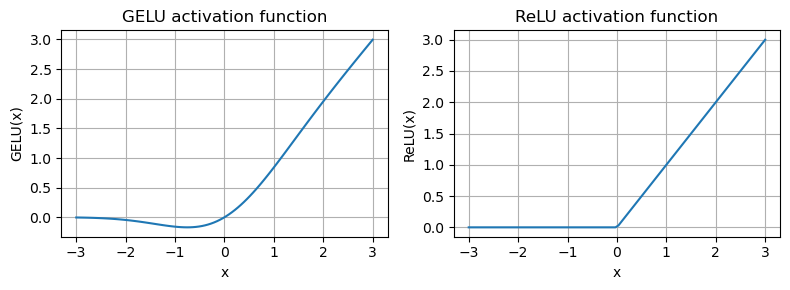

In [26]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


## 5.3. Then, implement feed-forward network.

<img src="./images/GPT_2-Feed_forward.png" alt="Context tokens" width="700" height="450">

In [27]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


## 5.4. After that, implement transformer block with skip connections.

In [28]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


## 5.5. Finally, our GPT architecture is implemented.

<img src="./images/GPT_2-GPT.png" alt="Context tokens" width="700" height="800">

In [29]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


## 5.6. Create a dummy input for testing GPT

In [30]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


## 5.7. Initialize random model weights with dummy text

In [31]:
torch.manual_seed(123)

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length (max num of input tokens model can handle via Positional embedding)
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of transformer blocks
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)


Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


#### Total number of parameters in our model

In [32]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")


Total number of parameters: 163,009,536


#### Shape of token embedding layer

In [33]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)


Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


#### Parameters in token embedding layer

In [34]:
token_params = sum(p.numel() for p in model.out_head.parameters())
print(f"Number of parameters in token embedding layer: {token_params:,}")


Number of parameters in token embedding layer: 38,597,376


#### Trainable parameters in our model

In [35]:
"""Token embedding matrix is reused as output matrix (weight typing)."""
total_params_gpt2 =  total_params - token_params
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")


Number of trainable parameters considering weight tying: 124,412,160


In [36]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")


Total size of the model: 621.83 MB


### 5.8. A function to generate text

<img src="./images/GPT_2-Text_generation.png" alt="Context tokens" width="800" height="500">

In [37]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


#### A sample text

In [38]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)


encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


#### Generate texts

<img src="./images/GPT_2-token_prediction.png" alt="Context tokens" width="800" height="500">

In [39]:
model.eval()  # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))


Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [40]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)


Hello, I am Featureiman Byeswickattribute argue


- Model is not trained not trained yet! 

# Great job!